<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4: Web Scraping Job Postings
## Business Case Overview

---
You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

Determine the industry factors that are most important in predicting the salary amounts for these data.
Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?
To limit the scope, your principal has suggested that you focus on data-related job postings, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by limiting your search to a single region.

Hint: Aggregators like Indeed.com regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---
## Directions
In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.

---
## Requirements
1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section.** One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).

    - Section 1: Job Salary Trends
    - Section 2: Job Category Factors
3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists.

    - Make sure to clearly describe and label each section.
    - Comment on your code so that others could, in theory, replicate your work.
    
4. A brief writeup in an executive summary, written for a non-technical audience.

    - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS
1. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.
2. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

## Suggestions for Getting Started
1. Collect data from [Indeed.com](https://www.indeed.com.sg/?r=us) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
    - Select and parse data from at least 1000 postings for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (e.g. title, location, department, etc).
    - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
    - Your Boss is interested in what overall features hold the greatest significance.
    - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.
4. Author an executive summary that details the highlights of your analysis for a non-technical audience.
5. If tackling the bonus question, try framing the salary problem as a classification problem detecting low vs. high salary positions.

### QUESTION 1: Factors that impact salary
To predict salary you will be building either a classification or regression model, using features like the location, title, and summary of the job. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will create labels from these salaries (high vs. low salary, for example) according to thresholds (such as median salary).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

### Web Scraping Job Postings
    There's a dropbox link provided below (right after markdown 'Question 1') to download the scraped data in .csv format.

In [1]:
# importing libraries
import numpy as np
from numpy import percentile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import time

sns.set_style("darkgrid")
%matplotlib inline

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

from scrapy.selector import Selector
from scrapy.http import HtmlResponse

from bs4 import BeautifulSoup
import urllib

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# accessing info from mycareersfuture.sg
# and disable pop-ups
chrome_options = webdriver.ChromeOptions()
prefs = {'profile.default_content_setting_values_notifications':2}
chrome_options.add_experimental_option('prefs',prefs)

driver = webdriver.Chrome(r'C:\Users\Quentin Koh\Desktop\chromedriver.exe',options=chrome_options)
driver.get('https://www.mycareersfuture.sg/')

time.sleep(3)

In [ ]:
# start web scraping
job_titles = ['data scientist','data analyst','data engineer','business analyst',
              'machine learning engineer','python developer','sql','analytics']       

job_list = []

for title in job_titles:
    search_list = []
    
    elem = driver.find_element_by_name('search-text')
    elem.clear()
    elem.send_keys(title)
    elem.send_keys(Keys.RETURN)
    
    time.sleep(12)
    
    try:
        driver.find_element_by_xpath("//span[@class='tr pointer OverlayNavigation__icon-cross___1wfSE']").click()
    except:
        pass
    
    time.sleep(12)
    
    try:
        driver.find_element_by_xpath("//button[@class='joyride-tooltip__close']").click()
    except:
        pass
    
    # start scraping to get job details for this particular job title
    
    # html label for first page source
    html1 = driver.page_source
    
    # covert html1 to soup object
    soup1 = BeautifulSoup(html1,'lxml')
    
    # jobs associated with searched title that are available on selected page
    jobs_first_page = Selector(text=html1).xpath("//h1[@class='f4-5 fw6 mv0 brand-sec dib mr2 JobCard__jobtitle___3HqOw']/text()").extract()    
    
    # calculating how many job pages for the associated job title
    jobs_found = soup1.find('span',{'id':'search-results-message'}).text
    
    # using regex to find the no. of jobs and then calculate no. of job pages
    match = re.search(r'\d+[,\d+]*',jobs_found)
    
    if match:
        jobs_num = int(match.group().replace(',',''))
    else:
        print('error or no jobs found!')

    pages_total = int(np.ceil(jobs_num/len(jobs_first_page)))
    
    print('{} job page\n'.format(title))
    
    for page in range(pages_total): 
        
        # html label
        html1 = driver.page_source

        # covert html1 to soup object
        soup1 = BeautifulSoup(html1,'lxml')
        
        jobs_in_page = Selector(text=html1).xpath("//h1[@class='f4-5 fw6 mv0 brand-sec dib mr2 JobCard__jobtitle___3HqOw']/text()").extract()
        
        for count in range(len(jobs_in_page)): 
            details = {}
            driver.find_element_by_id('job-card-' + str(count)).click()
            
            time.sleep(3)
            
            html3 = driver.page_source
            soup3 = BeautifulSoup(html3,'lxml')
    
            details['title'] = title
            
            if isinstance(soup3.find('p',{'name':'company'}), type(None)):
                    details['company'] = None
            else:
                details['company'] = soup3.find('p',{'name':'company'}).text

            if isinstance(soup3.find('h1',{'id':'job_title'}), type(None)):
                details['job'] = None
            else:
                details['job'] = soup3.find('h1',{'id':'job_title'}).text

            if isinstance(soup3.find('p',{'id':'address'}), type(None)):
                details['address'] = None
            else:
                details['address'] = soup3.find('p',{'id':'address'}).text

            if isinstance(soup3.find('p',{'id':'employment_type'}), type(None)):
                details['employment_type'] = None
            else:
                details['employment_type'] = soup3.find('p',{'id':'employment_type'}).text    

            if isinstance(soup3.find('p',{'id':'seniority'}), type(None)):
                details['seniority'] = None
            else:
                details['seniority'] = soup3.find('p',{'id':'seniority'}).text  
                
            if isinstance(soup3.find('p',{'id':'job-categories'}), type(None)):
                details['industry'] = None
            else:
                details['industry'] = soup3.find('p',{'id':'job-categories'}).text    

            if isinstance(soup3.find('div',{'class':'lh-solid'}), type(None)):
                details['salary'] = None
            else:
                details['salary'] = soup3.find('div',{'class':'lh-solid'}).text    

            if isinstance(soup3.find('span',{'class':'salary_type'}), type(None)):
                details['salary_type'] = None
            else:
                details['salary_type'] = soup3.find('span',{'class':'salary_type'}).text    

            if isinstance(soup3.find('div',{'id':'job_description'}), type(None)):
                details['responsibilities'] = None
            else:
                details['responsibilities'] = soup3.find('div',{'id':'job_description'}).text    

            if isinstance(soup3.find('div',{'id':'requirements'}), type(None)):
                details['requirements'] = None
            else:
                details['requirements'] = soup3.find('div',{'id':'requirements'}).text   
            
            search_list.append(details)
            
            driver.back()
            
            time.sleep(10)

            # close pop up window after returning to jobs' page
            try:
                driver.find_element_by_xpath("//button[@class='joyride-tooltip__close']").click()
            except:
                pass
            
        print('job page {} is scraped!'.format(page+1))
        
        html3 = driver.page_source
        soup3 = BeautifulSoup(html3,'lxml')
        
        pages_available = Selector(text=html3).xpath("//span[@type='action']/text()").extract()

        if '❯' in pages_available:
            change_index = pages_available.index('❯')

            driver.find_elements_by_xpath("//span[@type='action']")[change_index].click()
        
        time.sleep(3)
        
    for job in search_list:
        job_list.append(job)
    
    print('')
    print('{} finished scraping!\n'.format(title))
    print('no. of {} jobs scraped: {}'.format(title,len(search_list)))
    print('')
    print('no. of jobs {} available for this title on website: {}'.format(title,jobs_num))
    print('')
    
    if len(search_list) == jobs_num:
        print('all {} jobs have been scraped!'.format(title))
    else:
        print('some {} job(s) have not been scraped!'.format(title))
    
    print('')
    print('-'*30)
    print('')
    
    search_list_df = pd.DataFrame(search_list)
    search_list_df.to_csv(str(title)+'.csv',index=False)
    
    # go back to main page and search for subsequent job titles
    driver.find_element_by_xpath("//a[@class='no-underline pointer']").click()

# Question 1

https://www.dropbox.com/sh/hfx95izrdlbfn4u/AAA6P1s4Y_DM6w1laIhyTtNta?dl=0

In [2]:
# load data

job_titles = ['data scientist','data analyst','data engineer','business analyst',
              'machine learning engineer','python developer','sql','analytics']       

data_scientist = pd.read_csv('data scientist.csv')
data_analyst = pd.read_csv('data analyst.csv')
data_engineer = pd.read_csv('data engineer.csv')
business_analyst = pd.read_csv('business analyst.csv')
machine_learning_engineer = pd.read_csv('machine learning engineer.csv')
python_developer = pd.read_csv('python developer.csv')
sql = pd.read_csv('sql.csv')
analytics = pd.read_csv('analytics.csv')

In [3]:
# concatenate all dfs
jobs = pd.concat([data_scientist,data_analyst,data_engineer,business_analyst,
              machine_learning_engineer,python_developer,sql,analytics])

# reset_index
jobs.reset_index(drop=True,inplace=True)

In [4]:
jobs.head()

,address,company,employment_type,industry,job,requirements,responsibilities,salary,salary_type,seniority,title
0,"THE SIEMENS CENTRE, 60 MACPHERSON ROAD 348615",SIEMENS PTE. LTD.,Permanent,"Engineering, Information Technology",SENIOR DATA SCIENTIST (68722),RequirementsKey Skills and Experience Minimum...,Roles & ResponsibilitiesResponsibilities Coll...,"$5,000to$8,000",Monthly,"Professional, Senior Executive",data scientist
1,"THE ADELPHI, 1 COLEMAN STREET 179803",CAREER TREND PTE. LTD.,Full Time,Information Technology,Design Engineer / Electronic Component MNC / 5...,Requirements• Programming skills in C++/C and ...,Roles & ResponsibilitiesWork with marketing te...,"$4,000to$5,500",Monthly,Senior Executive,data scientist
2,NaN,Company Undisclosed,Permanent,Banking and Finance,Data Scientist,"Requirements Master’s or Ph.D. in statistics, ...",Roles & ResponsibilitiesThis role aims to offe...,"$8,000to$10,000",Monthly,"Professional, Executive",data scientist
3,NaN,Company Undisclosed,Full Time,Information Technology,IT Data Scientist (Generalist),Requirements Comfortable with core machine lea...,Roles & ResponsibilitiesThe Data Scientist sho...,"$7,000to$12,000",Monthly,Professional,data scientist
4,"LEE KING HWA BUILDING, 9 TAI SENG LINK 534053",QANVAST PTE. LTD.,Full Time,Information Technology,Data Scientist,Requirements Strong problem solving skills wi...,Roles & Responsibilities Work with stakeholde...,"$4,000to$6,000",Monthly,Junior Executive,data scientist


In [5]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2237 entries, 0 to 2236
Data columns (total 11 columns):
address             1635 non-null object
company             2199 non-null object
employment_type     2199 non-null object
industry            2199 non-null object
job                 2199 non-null object
requirements        2067 non-null object
responsibilities    2199 non-null object
salary              1962 non-null object
salary_type         1962 non-null object
seniority           2103 non-null object
title               2237 non-null object
dtypes: object(11)
memory usage: 192.3+ KB


In [6]:
jobs.isnull().sum()

address             602
company              38
employment_type      38
industry             38
job                  38
requirements        170
responsibilities     38
salary              275
salary_type         275
seniority           134
title                 0
dtype: int64

In [7]:
print('jobs df shape: {}'.format(jobs.shape))

jobs df shape: (2237, 11)


## Missing values in jobs df

In [8]:
# locating indexes of rows with target (i.e. salary) as NaN
null_target = jobs['salary'].isnull()
print('no. of missing target values: {}'.format(null_target.sum()),'\n')

null_target_indexlist = [i for i,v in enumerate(list(null_target)) if v == True]
print(null_target_indexlist[0:10],'\n')

# removing rows with target as NaN and reset_index
jobs.drop(null_target_indexlist,axis=0,inplace=True)
jobs.reset_index(drop=True,inplace=True)
print('jobs df shape: {}'.format(jobs.shape))

no. of missing target values: 275 

[6, 25, 36, 39, 58, 61, 85, 98, 105, 109] 

jobs df shape: (1962, 11)


In [9]:
# locating indexes of rows with addresses as NaN
null_address = jobs['address'].isnull()
print('no. of missing addresses: {}'.format(null_address.sum()),'\n')

null_address_indexlist = [i for i,v in enumerate(list(null_address)) if v == True]
print(null_address_indexlist[0:10],'\n')

# taking a look at rows with addresses as NaN
jobs.iloc[null_address_indexlist,:] # contains much useful info, we should not drop these rows

# changing null values to 'undisclosed'
jobs['address'][null_address_indexlist] = 'undisclosed'

no. of missing addresses: 484 

[2, 3, 6, 7, 11, 15, 16, 18, 19, 20] 



In [10]:
# locating indexes of rows with requirements as NaN
null_requirements = jobs['requirements'].isnull()
print('no. of missing requirements: {}'.format(null_requirements.sum()),'\n')

null_requirements_indexlist = [i for i,v in enumerate(list(null_requirements)) if v == True]
print(null_requirements_indexlist[0:10],'\n')

# taking a look at rows with requirements as NaN
jobs.iloc[null_requirements_indexlist,:]

# changing null values to 'undisclosed'
jobs['requirements'][null_requirements_indexlist] = 'undisclosed'

no. of missing requirements: 47 

[104, 119, 144, 204, 229, 857, 1045, 1046, 1173, 1206] 



In [11]:
# locating indexes of rows with seniority as NaN
null_seniority = jobs['seniority'].isnull()
print('no. of missing seniority: {}'.format(null_seniority.sum()),'\n')

null_seniority_indexlist = [i for i,v in enumerate(list(null_seniority)) if v == True]
print(null_seniority_indexlist[0:10],'\n')

# taking a look at rows with seniority as NaN
jobs.iloc[null_seniority_indexlist,:]

# changing null values to 'undisclosed'
jobs['seniority'][null_seniority_indexlist] = 'undisclosed'

no. of missing seniority: 34 

[857, 1321, 1322, 1530, 1931, 1933, 1934, 1935, 1936, 1937] 



In [12]:
# convert all string elements in jobs df to lowercase 
for col_name in list(jobs.columns.values):
    jobs[col_name] = jobs[col_name].map(lambda x: x.lower() if type(x) == str else x)

In [13]:
# featuring enginner on salary column to lower and upper boundaries on its range
salary_list = jobs['salary'].map(lambda x: str(x).replace('to',' ').replace('$','').replace(',','').split())

lower = []
upper = []

for left_col in range(len(salary_list)):
    lower.append(float(salary_list[left_col][0]))
    
for right_col in range(len(salary_list)):
    if len(salary_list[right_col]) == 1:
        upper.append(np.nan)
    else:
        upper.append(float(salary_list[right_col][1]))

# standardizing salary periodicity as monthly for all salaries and calculate salaries as such
salary_lower = [round(v/12,2) if jobs['salary_type'][i] == 'annually' else v for i,v in enumerate(lower)]
salary_upper = [round(v/12,2) if jobs['salary_type'][i] == 'annually' else v for i,v in enumerate(upper)]

# concat two new cols to jobs df
jobs['salary_lower_mth_num'] = salary_lower
jobs['salary_upper_mth_num'] = salary_upper 

In [14]:
# calculating and adding salary_mid column
jobs['salary_mid_mth_num'] = (jobs['salary_lower_mth_num']+jobs['salary_upper_mth_num'])/2

print('jobs shape: {}'.format(jobs.shape))

jobs shape: (1962, 14)


In [15]:
# removing potential duplicate(s) of jobs in jobs df and reset_index
jobs = jobs.drop_duplicates()

jobs.reset_index(drop=True,inplace=True)

print('jobs shape: {}'.format(jobs.shape))

jobs shape: (1877, 14)


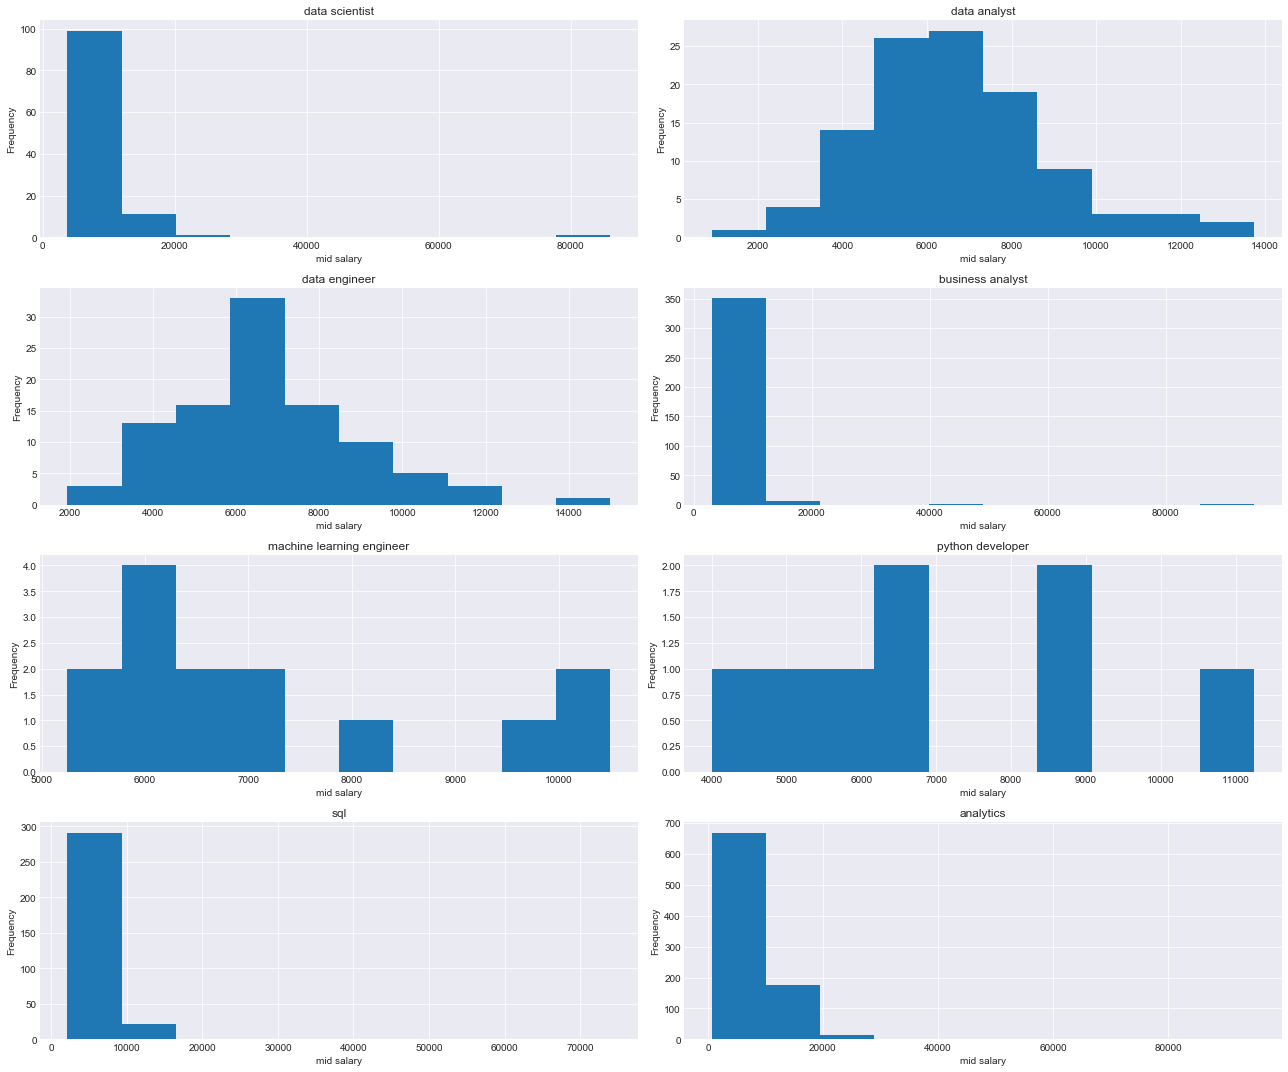

In [16]:
# histogram for mid salaries
fig, axes = plt.subplots(int(len(job_titles)/2),2,figsize=(18,15))

for i,v in enumerate(job_titles):
    g = jobs[jobs['title'] == v]['salary_mid_mth_num'].plot(kind='hist',ax=axes[int((i-i%2)/2), i%2],bins=10)
    g.set_title(v)
    g.set_xlabel('mid salary')
    plt.tight_layout()

Text(0.5,1,'hist of mid salaries')

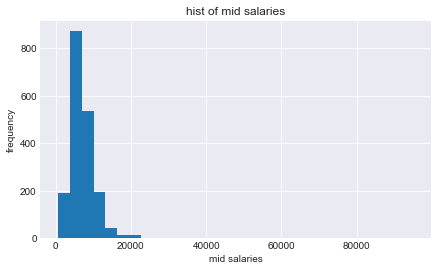

In [17]:
# histogram for all mid salaries
g1 = jobs['salary_mid_mth_num'].plot(kind='hist',bins=30,figsize=(7,4))
g1.set_xlabel('mid salaries')
g1.set_ylabel('frequency')
g1.set_title('hist of mid salaries')

## Creating decision boundary based on median of salary_mid_mth_num
    - Class of 1 is assigned to target if salary_mid_mth_num for data point is greater than or equal to median of salary_mid_mth_num
    
    - Class of 0 is assigned otherwise

In [18]:
# creating new feature called 'target' with decision boundary as described in markdown shown above
target = []

for i in range(jobs.shape[0]):
    if jobs['salary_mid_mth_num'][i] >= np.median(jobs['salary_mid_mth_num']):
        target.append(1)
    else:
        target.append(0)
        
# concat target vector to jobs df
jobs['target'] = target

print('len of target: {}'.format(len(target)),'\n')

# majority class will be our baseline
jobs['target'].value_counts()

if jobs['target'].value_counts()[0] > jobs['target'].value_counts()[1]:
    print('class 0 is our baseline with score: {}'.format(jobs['target'].value_counts()[0]/jobs.shape[0]))
else:
    print('class 1 is our baseline with score: {}'.format(jobs['target'].value_counts()[1]/jobs.shape[0]))

len of target: 1877 

class 1 is our baseline with score: 0.5578050079914758


In [19]:
# savings jobs df to .csv file
jobs.to_csv('jobs.csv',index=False)

# Tokenizing and Vectorizing of text + Model Fitting (below)

## train test split by 80/20
#### <font color='red'> job_text and target

In [20]:
x = jobs['job']
y = jobs['target']

xtrain_job, xtest_job, ytrain_job, ytest_job = train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_job shape: {}'.format(xtrain_job.shape))
print('ytrain_job shape: {}'.format(ytrain_job.shape))
print('')
print('xtest_job shape: {}'.format(xtest_job.shape))
print('ytest_job shape: {}'.format(ytest_job.shape))

xtrain_job shape: (1501,)
ytrain_job shape: (1501,)

xtest_job shape: (376,)
ytest_job shape: (376,)


## model fitting - randomforestclassifier
#### <font color='red'> job_text and target

In [21]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_job)
xtestdtm = cvec.transform(xtest_job)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_job)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_job = cross_val_score(rfc,X_train,ytrain_job,cv=10,scoring='roc_auc')
print(rfc_cvscore_job,'\n')
print('job mean auc score: {}'.format(np.mean(rfc_cvscore_job)),'\n')

# accuracy score
accuracyscore_job = accuracy_score(ytest_job,y_pred)
print('job accuracy score: {}'.format(accuracy_score(ytest_job,y_pred)))

X_train shape: (1501, 807) 

[0.83965273 0.78561304 0.77944614 0.7156087  0.80039561 0.85425283
 0.77647905 0.80606006 0.81145477 0.85183837] 

job mean auc score: 0.8020801314854914 

job accuracy score: 0.7340425531914894


## train test split by 80/20
#### <font color='red'> requirements_text and target

In [22]:
x = jobs['requirements']
y = jobs['target']

xtrain_requirements, xtest_requirements, ytrain_requirements, ytest_requirements\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_requirements shape: {}'.format(xtrain_requirements.shape))
print('ytrain_requirements shape: {}'.format(ytrain_requirements.shape))
print('')
print('xtest_requirements shape: {}'.format(xtest_requirements.shape))
print('ytest_requirements shape: {}'.format(ytest_requirements.shape))

xtrain_requirements shape: (1501,)
ytrain_requirements shape: (1501,)

xtest_requirements shape: (376,)
ytest_requirements shape: (376,)


## model fitting - randomforestclassifier
#### <font color='red'> requirements_text and target

In [23]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_requirements)
xtestdtm = cvec.transform(xtest_requirements)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_requirements)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_requirements = cross_val_score(rfc,X_train,ytrain_requirements,cv=10,scoring='roc_auc')
print(rfc_cvscore_requirements,'\n')
print('requirements mean auc score: {}'.format(np.mean(rfc_cvscore_requirements)),'\n')

# accuracy score
accuracyscore_requirements = accuracy_score(ytest_requirements,y_pred)
print('requirements accuracy score: {}'.format(accuracyscore_requirements))

X_train shape: (1501, 7396) 

[0.87880936 0.87127923 0.88590182 0.85668045 0.86558173 0.86117605
 0.82736918 0.82988671 0.86755979 0.80278486] 

requirements mean auc score: 0.854702917324666 

requirements accuracy score: 0.8031914893617021


## train test split by 80/20
#### <font color='red'> responsibilities_text and target

In [24]:
x = jobs['responsibilities']
y = jobs['target']

xtrain_responsibilities, xtest_responsibilities, ytrain_responsibilities, ytest_responsibilities\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_responsibilities shape: {}'.format(xtrain_responsibilities.shape))
print('ytrain_responsibilities shape: {}'.format(ytrain_responsibilities.shape))
print('')
print('xtest_responsibilities shape: {}'.format(xtest_responsibilities.shape))
print('ytest_responsibilities shape: {}'.format(ytest_responsibilities.shape))

xtrain_responsibilities shape: (1501,)
ytrain_responsibilities shape: (1501,)

xtest_responsibilities shape: (376,)
ytest_responsibilities shape: (376,)


## model fitting - randomforestclassifier
#### <font color='red'> responsibilities_text and target

In [25]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_responsibilities)
xtestdtm = cvec.transform(xtest_responsibilities)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_responsibilities)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_responsibilities = cross_val_score(rfc,X_train,ytrain_responsibilities,cv=10,scoring='roc_auc')
print(rfc_cvscore_responsibilities,'\n')
print('responsibilities mean auc score: {}'.format(np.mean(rfc_cvscore_responsibilities)),'\n')

# accuracy score
accuracyscore_responsibilities = accuracy_score(ytest_responsibilities,y_pred)
print('responsibilities accuracy score: {}'.format(accuracy_score(ytest_responsibilities,y_pred)))

X_train shape: (1501, 9162) 

[0.81431609 0.86888731 0.8539831  0.81586046 0.86225499 0.88104657
 0.8138824  0.84894803 0.89624168 0.83636695] 

responsibilities mean auc score: 0.84917875747191 

responsibilities accuracy score: 0.7845744680851063


## train test split by 80/20
#### <font color='red'> seniority_text and target

In [26]:
x = jobs['seniority']
y = jobs['target']

xtrain_seniority, xtest_seniority, ytrain_seniority, ytest_seniority\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_seniority shape: {}'.format(xtrain_seniority.shape))
print('ytrain_seniority shape: {}'.format(ytrain_seniority.shape))
print('')
print('xtest_seniority shape: {}'.format(xtest_seniority.shape))
print('ytest_seniority shape: {}'.format(ytest_seniority.shape))

xtrain_seniority shape: (1501,)
ytrain_seniority shape: (1501,)

xtest_seniority shape: (376,)
ytest_seniority shape: (376,)


## model fitting - randomforestclassifier
#### <font color='red'> seniority_text and target

In [27]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_seniority)
xtestdtm = cvec.transform(xtest_seniority)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_seniority)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_seniority = cross_val_score(rfc,X_train,ytrain_seniority,cv=10,scoring='roc_auc')
print(rfc_cvscore_seniority,'\n')
print('seniority mean auc score: {}'.format(np.mean(rfc_cvscore_seniority)),'\n')

# accuracy score
accuracyscore_seniority = accuracy_score(ytest_seniority,y_pred)
print('seniority accuracy score: {}'.format(accuracyscore_seniority))

X_train shape: (1501, 12) 

[0.70614812 0.73750886 0.64313972 0.70311095 0.75391117 0.76955584
 0.6633699  0.6770365  0.72109333 0.78285402] 

seniority mean auc score: 0.715772841037591 

seniority accuracy score: 0.7074468085106383


## train test split by 80/20
#### <font color='red'> title_text and target

In [28]:
x = jobs['title']
y = jobs['target']

xtrain_title, xtest_title, ytrain_title, ytest_title\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_title shape: {}'.format(xtrain_title.shape))
print('ytrain_title shape: {}'.format(ytrain_title.shape))
print('')
print('xtest_title shape: {}'.format(xtest_title.shape))
print('ytest_title shape: {}'.format(ytest_title.shape))

xtrain_title shape: (1501,)
ytrain_title shape: (1501,)

xtest_title shape: (376,)
ytest_title shape: (376,)


## model fitting - randomforestclassifier
#### <font color='red'> title_text and target

In [29]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_title)
xtestdtm = cvec.transform(xtest_title)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_title)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_title = cross_val_score(rfc,X_train,ytrain_title,cv=10,scoring='roc_auc')
print(rfc_cvscore_title,'\n')
print('title mean auc score: {}'.format(np.mean(rfc_cvscore_title)),'\n')

# accuracy score
accuracyscore_title = accuracy_score(ytest_title,y_pred)
print('title accuracy score: {}'.format(accuracyscore_title))

X_train shape: (1501, 11) 

[0.59018427 0.56156981 0.64808488 0.58595576 0.66130192 0.65006294
 0.57687466 0.54639453 0.63486783 0.58281762] 

title mean auc score: 0.6038114222667238 

title accuracy score: 0.5957446808510638


# summary scores for q1

In [30]:
features = ['job','requirements','responsibilities','seniority','title']

summary_scores = pd.DataFrame({'features':features,
                               'rfc_mean_cvscore':[np.mean(rfc_cvscore_job),
                                                   np.mean(rfc_cvscore_requirements),
                                                   np.mean(rfc_cvscore_responsibilities),
                                                   np.mean(rfc_cvscore_seniority),
                                                   np.mean(rfc_cvscore_title)],
                               'accuracy_score':[accuracyscore_job,
                                                accuracyscore_requirements,
                                                accuracyscore_responsibilities,
                                                accuracyscore_seniority,
                                                accuracyscore_title]})

summary_scores

,features,rfc_mean_cvscore,accuracy_score
0,job,0.802080,0.734043
1,requirements,0.854703,0.803191
2,responsibilities,0.849179,0.784574
3,seniority,0.715773,0.707447
4,title,0.603811,0.595745


### QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:

- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

In [31]:
# looking for job titles with the words 'data scientist' in them
data_index = []

for i in range(jobs.shape[0]):
    try:
        if re.findall(r'\bdata scientist\b',jobs['job'][i])[0] == 'data scientist':
            data_index.append(i)
    except:
        pass
    
print('len data_index: {}'.format(len(data_index)),'\n')
print(data_index[0:10],'\n')

# taking a look at 'job' feature's value_counts
jobs.iloc[data_index,:]['job'].value_counts() 

len data_index: 121 

[0, 2, 3, 4, 5, 7, 8, 9, 10, 11] 



data scientist                                                                                          64
senior data scientist                                                                                   13
data scientist 12 month contract                                                                         4
senior data scientist, app store analytics - business & marketing                                        4
senior analytics manager - data scientist                                                                3
vp, data scientist, business analytics, consumer banking group (1800016v)                                3
lead data scientist                                                                                      3
senior data scientist (smallholder digital lab)                                                          2
vp  /  avp, data scientist, investment and trading technology, technology and operations  (180002yf)     2
svp / vp, lead data scientist, group 

## Creating decision boundary based on job titles that contain the word 'data scientist'
    - Class of 1 is assigned to target if job title contains the word 'data scientist'
    
    - Class of 0 is assigned otherwise

In [32]:
# concat 'target_jobtitle' column to jobs df as target for job titles
jobs['target_jobtitle'] = 0

jobs.loc[data_index,'target_jobtitle'] = 1

print('jobs shape: {}'.format(jobs.shape))

jobs shape: (1877, 16)


class 1 count: 121 

class 0 count: 1756 

proportion of class 1: 6.446457112413426 



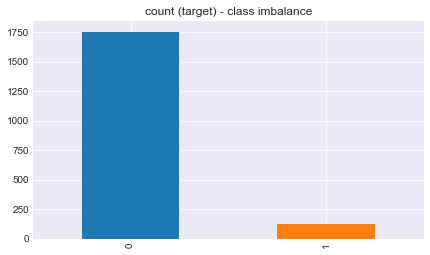

In [33]:
# class imbalance issue for target_jobtitle column
jobs['target_jobtitle'].value_counts()

print('class 1 count: {}'.format(jobs['target_jobtitle'].value_counts()[1]),'\n')
print('class 0 count: {}'.format(jobs['target_jobtitle'].value_counts()[0]),'\n')
print('proportion of class 1: {}'.format(jobs['target_jobtitle'].value_counts()[1]/(jobs['target_jobtitle'].value_counts()[0]+jobs['target_jobtitle'].value_counts()[1])*100),'\n')

# plot the value_counts
jobs['target_jobtitle'].value_counts().plot(kind='bar',title='count (target) - class imbalance',figsize=(7,4))

jobs1 shape: (121, 16) 

jobs0 shape: (1756, 16) 

1    1756
0    1756
Name: target_jobtitle, dtype: int64 

jobs_over shape: (3512, 16) 



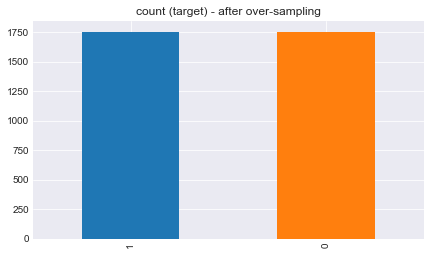

In [34]:
# over-sampling from minority class of 1

# class count
count0,count1 = jobs['target_jobtitle'].value_counts()

# divide jobs df by class
jobs1 = jobs[jobs['target_jobtitle'] == 1]
jobs0 = jobs[jobs['target_jobtitle'] == 0]

print('jobs1 shape: {}'.format(jobs1.shape),'\n')
print('jobs0 shape: {}'.format(jobs0.shape),'\n')

jobs1_over = jobs1.sample(count0,replace=True)

# concat jobs0 df which has target_jobtitle = 0 and jobs1_over df which has oversampled minority
# class of 1
jobs_over = pd.concat([jobs0,jobs1_over],axis=0)
jobs_over.reset_index(drop=True,inplace=True)

print(jobs_over['target_jobtitle'].value_counts(),'\n')
print('jobs_over shape: {}'.format(jobs_over.shape),'\n')

# plot value_counts - what happens after over-sampling
jobs_over['target_jobtitle'].value_counts().plot(kind='bar',title='count (target) - after over-sampling',figsize=(7,4))

## train test split by 80/20
#### <font color='red'> requirements_text and target_jobtitle

In [35]:
x = jobs_over['requirements']
y = jobs_over['target_jobtitle']

xtrain_requirements, xtest_requirements, ytrain_requirements, ytest_requirements\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_requirements shape: {}'.format(xtrain_requirements.shape))
print('ytrain_requirements shape: {}'.format(ytrain_requirements.shape))
print('')
print('xtest_requirements shape: {}'.format(xtest_requirements.shape))
print('ytest_requirements shape: {}'.format(ytest_requirements.shape))

xtrain_requirements shape: (2809,)
ytrain_requirements shape: (2809,)

xtest_requirements shape: (703,)
ytest_requirements shape: (703,)


## model fitting - randomforestclassifier
#### <font color='red'> requirements_text and target_jobtitle

In [36]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_requirements)
xtestdtm = cvec.transform(xtest_requirements)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_requirements)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_requirements = cross_val_score(rfc,X_train,ytrain_requirements,cv=10,scoring='roc_auc')
print(rfc_cvscore_requirements,'\n')
print('requirements mean auc score: {}'.format(np.mean(rfc_cvscore_requirements)),'\n')

# accuracy score
accuracyscore_requirements = accuracy_score(ytest_requirements,y_pred)
print('requirements accuracy score: {}'.format(accuracyscore_requirements),'\n')

# confusion matrix
print('')
print(confusion_matrix(ytest_requirements, y_pred),'\n')

# classification report
print(classification_report(ytest_requirements,y_pred),'\n')

X_train shape: (2809, 7290) 

[0.99967299 1.         1.         0.99982264 1.         0.99959461
 1.         0.99617269 1.         1.        ] 

requirements mean auc score: 0.9995262926602606 

requirements accuracy score: 0.9971550497866287 


[[371   2]
 [  0 330]] 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       373
           1       0.99      1.00      1.00       330

   micro avg       1.00      1.00      1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703
 



## train test split by 80/20
#### <font color='red'> responsibilities_text and target_jobtitle

In [37]:
x = jobs_over['responsibilities']
y = jobs_over['target_jobtitle']

xtrain_responsibilities, xtest_responsibilities, ytrain_responsibilities, ytest_responsibilities\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_responsibilities shape: {}'.format(xtrain_responsibilities.shape))
print('ytrain_responsibilities shape: {}'.format(ytrain_responsibilities.shape))
print('')
print('xtest_responsibilities shape: {}'.format(xtest_responsibilities.shape))
print('ytest_responsibilities shape: {}'.format(ytest_responsibilities.shape))

xtrain_responsibilities shape: (2809,)
ytrain_responsibilities shape: (2809,)

xtest_responsibilities shape: (703,)
ytest_responsibilities shape: (703,)


## model fitting - randomforestclassifier
#### <font color='red'> responsibilities_text and target_jobtitle

In [38]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_responsibilities)
xtestdtm = cvec.transform(xtest_responsibilities)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_responsibilities)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_responsibilities = cross_val_score(rfc,X_train,ytrain_responsibilities,cv=10,scoring='roc_auc')
print(rfc_cvscore_responsibilities,'\n')
print('responsibilities mean auc score: {}'.format(np.mean(rfc_cvscore_responsibilities)),'\n')

# accuracy score
accuracyscore_responsibilities = accuracy_score(ytest_responsibilities,y_pred)
print('responsibilities accuracy score: {}'.format(accuracy_score(ytest_responsibilities,y_pred)))

# confusion matrix
print('')
print(confusion_matrix(ytest_responsibilities, y_pred),'\n')

# classification report
print(classification_report(ytest_responsibilities,y_pred),'\n')

X_train shape: (2809, 9052) 

[0.99967299 1.         1.         0.99982264 1.         0.99959461
 1.         0.99617269 1.         1.        ] 

responsibilities mean auc score: 0.9995262926602606 

responsibilities accuracy score: 0.9971550497866287

[[371   2]
 [  0 330]] 

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       373
           1       0.99      1.00      1.00       330

   micro avg       1.00      1.00      1.00       703
   macro avg       1.00      1.00      1.00       703
weighted avg       1.00      1.00      1.00       703
 



## train test split by 80/20
#### <font color='red'> seniority_text and target_jobtitle

In [39]:
x = jobs_over['seniority']
y = jobs_over['target_jobtitle']

xtrain_seniority, xtest_seniority, ytrain_seniority, ytest_seniority\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_seniority shape: {}'.format(xtrain_seniority.shape))
print('ytrain_seniority shape: {}'.format(ytrain_seniority.shape))
print('')
print('xtest_seniority shape: {}'.format(xtest_seniority.shape))
print('ytest_seniority shape: {}'.format(ytest_seniority.shape))

xtrain_seniority shape: (2809,)
ytrain_seniority shape: (2809,)

xtest_seniority shape: (703,)
ytest_seniority shape: (703,)


## model fitting - randomforestclassifier
#### <font color='red'> seniority_text and target_jobtitle

In [40]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_seniority)
xtestdtm = cvec.transform(xtest_seniority)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_seniority)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_seniority = cross_val_score(rfc,X_train,ytrain_seniority,cv=10,scoring='roc_auc')
print(rfc_cvscore_seniority,'\n')
print('seniority mean auc score: {}'.format(np.mean(rfc_cvscore_seniority)),'\n')

# accuracy score
accuracyscore_seniority = accuracy_score(ytest_seniority,y_pred)
print('seniority accuracy score: {}'.format(accuracyscore_seniority))

# confusion matrix
print('')
print(confusion_matrix(ytest_seniority, y_pred),'\n')

# classification report
print(classification_report(ytest_seniority,y_pred),'\n')

X_train shape: (2809, 12) 

[0.62574835 0.58980228 0.60102128 0.67403973 0.64958954 0.64087362
 0.64457032 0.63382833 0.6427077  0.57935293] 

seniority mean auc score: 0.6281534083110826 

seniority accuracy score: 0.566145092460882

[[101 272]
 [ 33 297]] 

              precision    recall  f1-score   support

           0       0.75      0.27      0.40       373
           1       0.52      0.90      0.66       330

   micro avg       0.57      0.57      0.57       703
   macro avg       0.64      0.59      0.53       703
weighted avg       0.64      0.57      0.52       703
 



## train test split by 80/20
#### <font color='red'> title_text and target_jobtitle

In [41]:
x = jobs_over['title']
y = jobs_over['target_jobtitle']

xtrain_title, xtest_title, ytrain_title, ytest_title\
= train_test_split(x,y,test_size=0.2,random_state=42)

print('xtrain_title shape: {}'.format(xtrain_title.shape))
print('ytrain_title shape: {}'.format(ytrain_title.shape))
print('')
print('xtest_title shape: {}'.format(xtest_title.shape))
print('ytest_title shape: {}'.format(ytest_title.shape))

xtrain_title shape: (2809,)
ytrain_title shape: (2809,)

xtest_title shape: (703,)
ytest_title shape: (703,)


## model fitting - randomforestclassifier
#### <font color='red'> title_text and target_jobtitle

In [42]:
cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_title)
xtestdtm = cvec.transform(xtest_title)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

print('X_train shape: {}'.format(X_train.shape),'\n')

# model fitting
rfc = RandomForestClassifier(n_estimators=100,random_state=42)
rfc.fit(X_train,ytrain_title)

y_pred = rfc.predict(X_test)

# 10-folds cv
rfc_cvscore_title = cross_val_score(rfc,X_train,ytrain_title,cv=10,scoring='roc_auc')
print(rfc_cvscore_title,'\n')
print('title mean auc score: {}'.format(np.mean(rfc_cvscore_title)),'\n')

# accuracy score
accuracyscore_title = accuracy_score(ytest_title,y_pred)
print('title accuracy score: {}'.format(accuracyscore_title))

# confusion matrix
print('')
print(confusion_matrix(ytest_title, y_pred),'\n')

# classification report
print(classification_report(ytest_title,y_pred),'\n')

X_train shape: (2809, 11) 

[0.89040097 0.89374654 0.87628918 0.85697274 0.88253775 0.87437924
 0.86956522 0.84468769 0.86150235 0.87056032] 

title mean auc score: 0.8720641993678555 

title accuracy score: 0.7923186344238976

[[363  10]
 [136 194]] 

              precision    recall  f1-score   support

           0       0.73      0.97      0.83       373
           1       0.95      0.59      0.73       330

   micro avg       0.79      0.79      0.79       703
   macro avg       0.84      0.78      0.78       703
weighted avg       0.83      0.79      0.78       703
 



# Text features that can identify job title of 'data scientist' from others
The roc-auc, precision and recall scores for RFC model of requirements_text and responsibilities_text predicting target_jobtitle (class 1: data scientist and class 0: others) are highly dubious. this is likely to due over-sampling of our minority class of 1, which caused overfitting of model.

However, we are still going ahead and pick the RFC model of requirements_text being vectorized into text features to predict target_jobtitle to find out which are the features that appear the most that may help to predict classes of 1 and 0.

The top twenty words that appear the most as text features from responsibilities_text are shown below.

In [43]:
# words that appear the most 
x = jobs_over['requirements']
y = jobs_over['target_jobtitle']

xtrain_requirements, xtest_requirements, ytrain_requirements, ytest_requirements\
= train_test_split(x,y,test_size=0.2,random_state=42)

cvec = CountVectorizer(stop_words='english')
xtraindtm = cvec.fit_transform(xtrain_requirements)
xtestdtm = cvec.transform(xtest_requirements)

# creating dataframes after tokenizing and vectorizing our text features
X_train = pd.DataFrame(xtraindtm.todense(),columns=[cvec.get_feature_names()])
X_test = pd.DataFrame(xtestdtm.todense(),columns=[cvec.get_feature_names()])

word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending=False).head(20)

experience      9166
data            7088
skills          3706
knowledge       2652
years           2582
science         2402
learning        2369
strong          2287
analytics       2099
requirements    1945
computer        1939
ability         1914
business        1826
working         1772
tools           1704
degree          1689
machine         1639
python          1607
good            1583
analysis        1525
dtype: int64

# Writeup

Through the analysis of data-related job postings retrieved from https://www.mycareersfuture.sg/, our predictive model has about 85% chance of correctly predicting whether a job is a high-paying one or low-paying one. The decision boundary of defining a job as high-paying is when the actual salary is greater than or equal to SGD 6,500 (the median salary based on job postings) and a low-paying job is defined as actual salary lower than SGD 6,500. The model also describes that requirements and responsibilities of a job have the best predictive value to our model as compared to other fields such as job title and seniority.

Moreover, we had came up with a second model that tries to predict if a job posting is looking to hire a data scientist and similarly, responsibilities of a job has the best predictive value. In this second model, words such as experience, data, skills, knowlege and years are our top five words that appear most frequently in our responsibilities section of a job posting. 

Although our second model did well in making predictions, it has its limitations in terms of having a greater chance of predicting that a job is likely to be hiring for a data scientist when it is not in reality. This is because in our job postings retrieved from website mentioned above, the number of such postings looking to hire data scientist are much lower than postings that are hiring for other data-related positions. As such, our data set of job postings were adjusted such that there is a better balance between both types of job postings. This adjustment may have given us the benefit of making pretty accurate predictions based on laboratory settings, however, when it's deployed in production, the model may not do as well because it has learned too well in lab and may not be able to generalize well in field settings.

### BONUS PROBLEM
Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.